In [1]:
!wget https://kapkic.github.io/Files/colabkit-2.zip
!unzip colabkit-2.zip

Archive:  colabkit.zip
  inflating: 00_VariateRanking_Electric_Lead1.csv  
  inflating: East Zone Room Cooling Setpoint(K).csv  
  inflating: hist_series.csv         
  inflating: Input/Ann_Tus_TMY3_Trans_Hourly_Electric_Lead1.csv  
  inflating: Input/Ann_Tus_TMY3_Trans_Hourly_Electric_Lead5.csv  
  inflating: Input/Ann_Tus_TMY3_Trans_Hourly_Electric_NoWeekend_Lead1.csv  
  inflating: Input/Ann_Tus_TMY3_Trans_Hourly_Electric_Occ_Lead1.csv  
  inflating: Output/00_VariateRanking_Electric_Lead1.csv  
  inflating: Output/AHU mixed air temperature(K).csv  
  inflating: Output/AHU outdoor air dry bulb temperature(K).csv  
  inflating: Output/AHU outdoor air wet bulb temperature(K).csv  
  inflating: Output/AHU return air temperature(K).csv  
  inflating: Output/AHU supply air duct static pressure setpoint(Pa).csv  
  inflating: Output/AHU supply air fan speed.csv  
  inflating: Output/AHU supply air temperature set point(K).csv  
  inflating: Output/AHU supply air temperature(K).csv  
  inf

In [2]:
### Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
import matplotlib
import matplotlib.patches as mpatches

#Config: Disable Warning
import warnings # Disable the warning
warnings.filterwarnings('ignore')

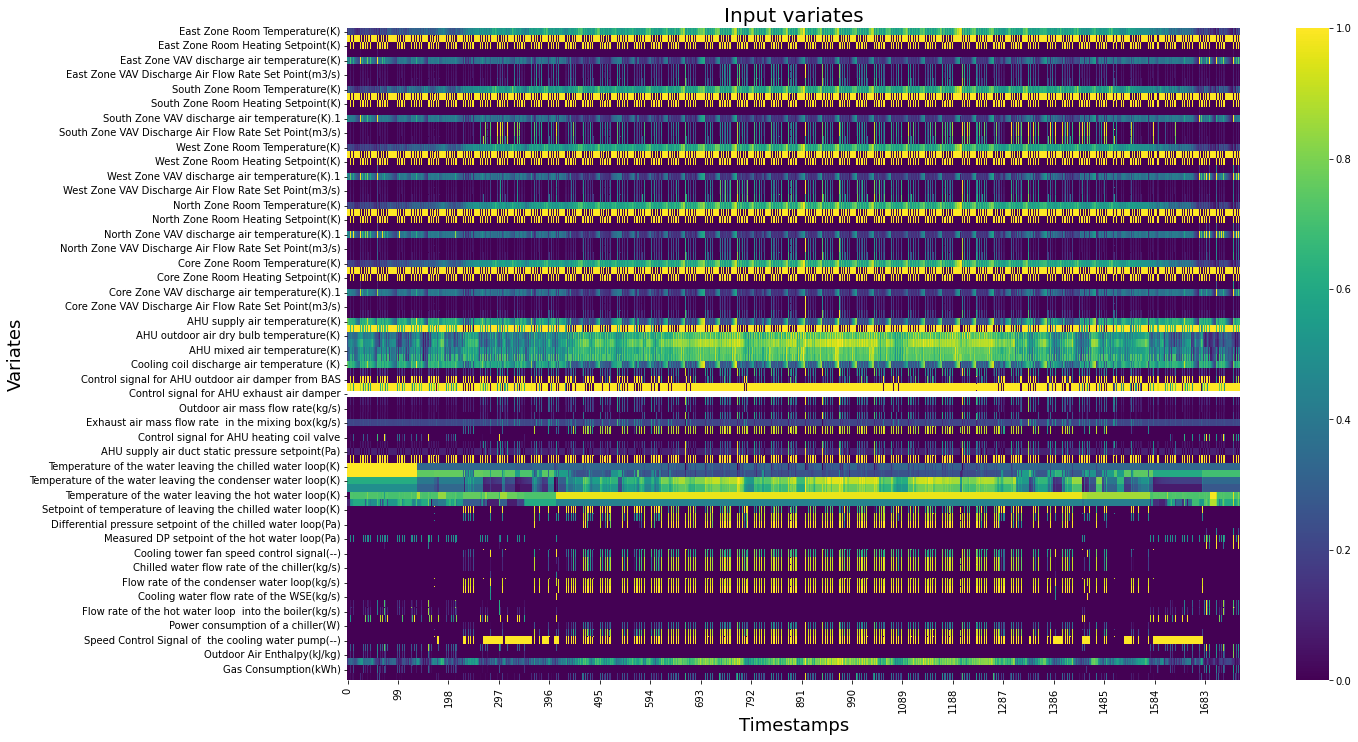

In [3]:
input_path = "Input/Ann_Tus_TMY3_Trans_Hourly_Electric_Lead1.csv"
input_data = pd.read_csv(input_path)

input_data_norm = (input_data - input_data.min()) / (input_data.max() - input_data.min())
X_input_data = input_data_norm

plt.figure(figsize=(20,12))
# sns.set_style('whitegrid')

sns.heatmap(X_input_data.T, cmap="viridis")
plt.locator_params('x', nbins=20)
plt.xlabel('Timestamps', fontsize=18)
plt.ylabel("Variates", fontsize=18)
plt.title("Input variates", fontsize=20)
plt.show()

Text(0.5, 1.0, 'Ranked Selego RMT variates based on importance')

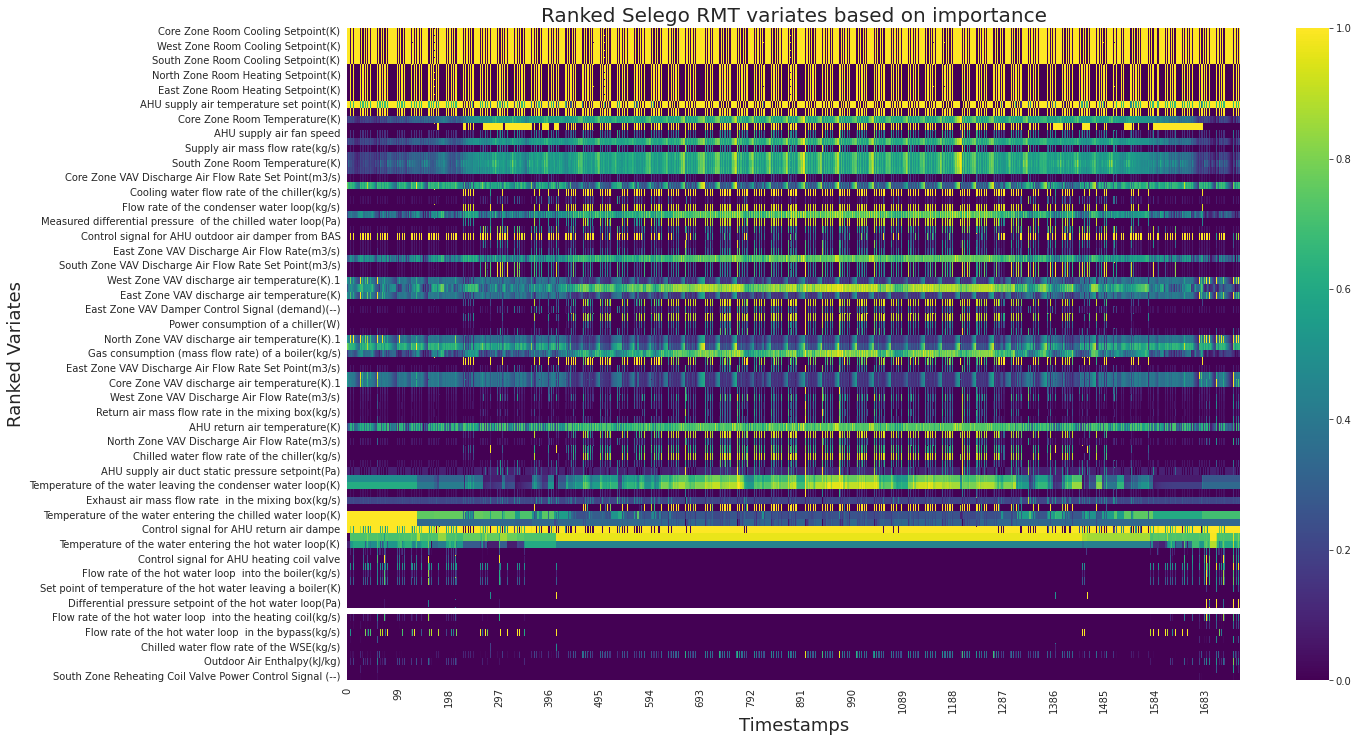

In [4]:
# Variate names
output_path = 'Output/00_VariateRanking_Electric_Lead1.csv'
ranked_variates = pd.read_csv(output_path, header=None)
ranked_variates = ranked_variates.rename(columns = {0 : 'RankedFeatures'})
ranked_variates_list = ranked_variates['RankedFeatures'].tolist()

ranked_X_data = X_input_data[ranked_variates_list]
ranked_X_data.head()

plt.figure(figsize=(20,12))
sns.set_style('whitegrid')

sns.heatmap(ranked_X_data.T, cmap="viridis")
plt.locator_params('x', nbins=20)
plt.xlabel('Timestamps', fontsize=18)
plt.ylabel("Ranked Variates", fontsize=18)
plt.title("Ranked Selego RMT variates based on importance", fontsize=20)
# plt.show()

In [5]:
# Name fixed: matched with parameters data
ranked_X_data.columns = ranked_X_data.columns.str.replace('/','')
## Columns name which has file from Matlab code
# data_info_col = ranked_X_data[['East Zone Room Cooling Setpoint(K)', \
#              'East Zone Room Heating Setpoint(K)', 'East Zone Room Temperature(K)', \
#              'East Zone VAV Damper Control Signal (demand)(--)', 'East Zone VAV discharge air temperature(K)']]

data_info_col = ranked_X_data.iloc[:, 0:50] 
## Why do we drop 39 columns? Why do we drop it from the last part? Investigate. -Kapkic
# Ranked_X_data is 8760x89, whereas data_info_col is 8760x51

data_info_col = pd.concat([ranked_X_data[['Overall Electric Power Consumption of the HVAC System(kWh)']], data_info_col], axis=1)

#Variate names into CSV naming.
data_info_cols = data_info_col.columns.tolist()
csv_string = '.csv'
data_info_cols = [x + csv_string for x in data_info_cols]

In [6]:
all_csvs = []

for file in data_info_cols:
    #csv_file =  pd.read_csv("../../../Outputs/Modelica-G36/FaultFree/"+file)
    csv_file =  pd.read_csv("Output/"+file)
#     print(csv_file)
    variate_name = os.path.basename(file)
#     print(variate_name)
    variate_name = os.path.splitext(variate_name)[0]
    csv_file = csv_file.T
    csv_file.insert(0, 'Variate_name', variate_name)
    csv_file['Variate_name'] = variate_name
    ## Drop unused columns for task
    csv_file = csv_file.drop(columns=[0, 3])
#     display(csv_file)
    all_csvs.append(csv_file)

# lump into one table
all_csvs = pd.concat(all_csvs)

# display(all_csvs[0])

# all_csvs = all_csvs.rename(columns={0:'variates_name', 1:'time_temporal_event_center', 
#                                     2:'std_temporal_event', 3:'avg_event_amp', 4:'octave_event'})

def double_time(df):
    df_double = df[1]*2**(df[4]-1)
    return df_double

all_csvs['double_time_len'] = all_csvs.apply(double_time, axis=1)

v1 = data_info_col[['East Zone Room Cooling Setpoint(K)']]
v1_params = all_csvs[all_csvs['Variate_name'] == 'Core Zone VAV Discharge Air Flow Rate(m3s)']

In [7]:
def gauss_fn(t, t_i, sigma_i):
        return np.random.normal(t_i, sigma_i, t)


def M_v_i_all(df_in, df_in_param):
    
    all_M_v_i = []
    for param in range(len(df_in_param)):
        t_i = df_in_param['double_time_len'][param]
        sigma_i = df_in_param[2][param]
        
        M_v_i_vals = gauss_fn(len(df_in), t_i, sigma_i)
        M_v_i_vals = pd.DataFrame(M_v_i_vals)
        all_M_v_i.append(M_v_i_vals)
    all_M_v = pd.concat(all_M_v_i, axis=1)
  
    return all_M_v

def combine_sensor_data(data_info_col, all_csvs):
    
    # read in all the csv files
    variate_name_list = []
#     files = Path("../../../outputs/Modelica-G36/FaultFree").rglob("*.csv")
    sensor_data = {}
    
#     for file in files:
#         variate_name = os.path.basename(file)
#         variate_name = os.path.splitext(variate_name)[0]
#         variate_name_list.append(variate_name)
    for file in data_info_cols:
#         csv_file =  pd.read_csv("../../../outputs/Modelica-G36/FaultFree/"+file)
        variate_name = os.path.basename(file)
        variate_name = os.path.splitext(variate_name)[0]
        variate_name_list.append(variate_name)
    
    
    
    for var_name in variate_name_list:
        variate_params = all_csvs[all_csvs['Variate_name'] == var_name]
        M_v_i_tot = M_v_i_all(data_info_col[[var_name]], variate_params)
        sensor_data[var_name] = M_v_i_tot
    return sensor_data


In [8]:
M_v_1 = M_v_i_all(v1, v1_params)
M_v_i = combine_sensor_data(data_info_col, all_csvs)

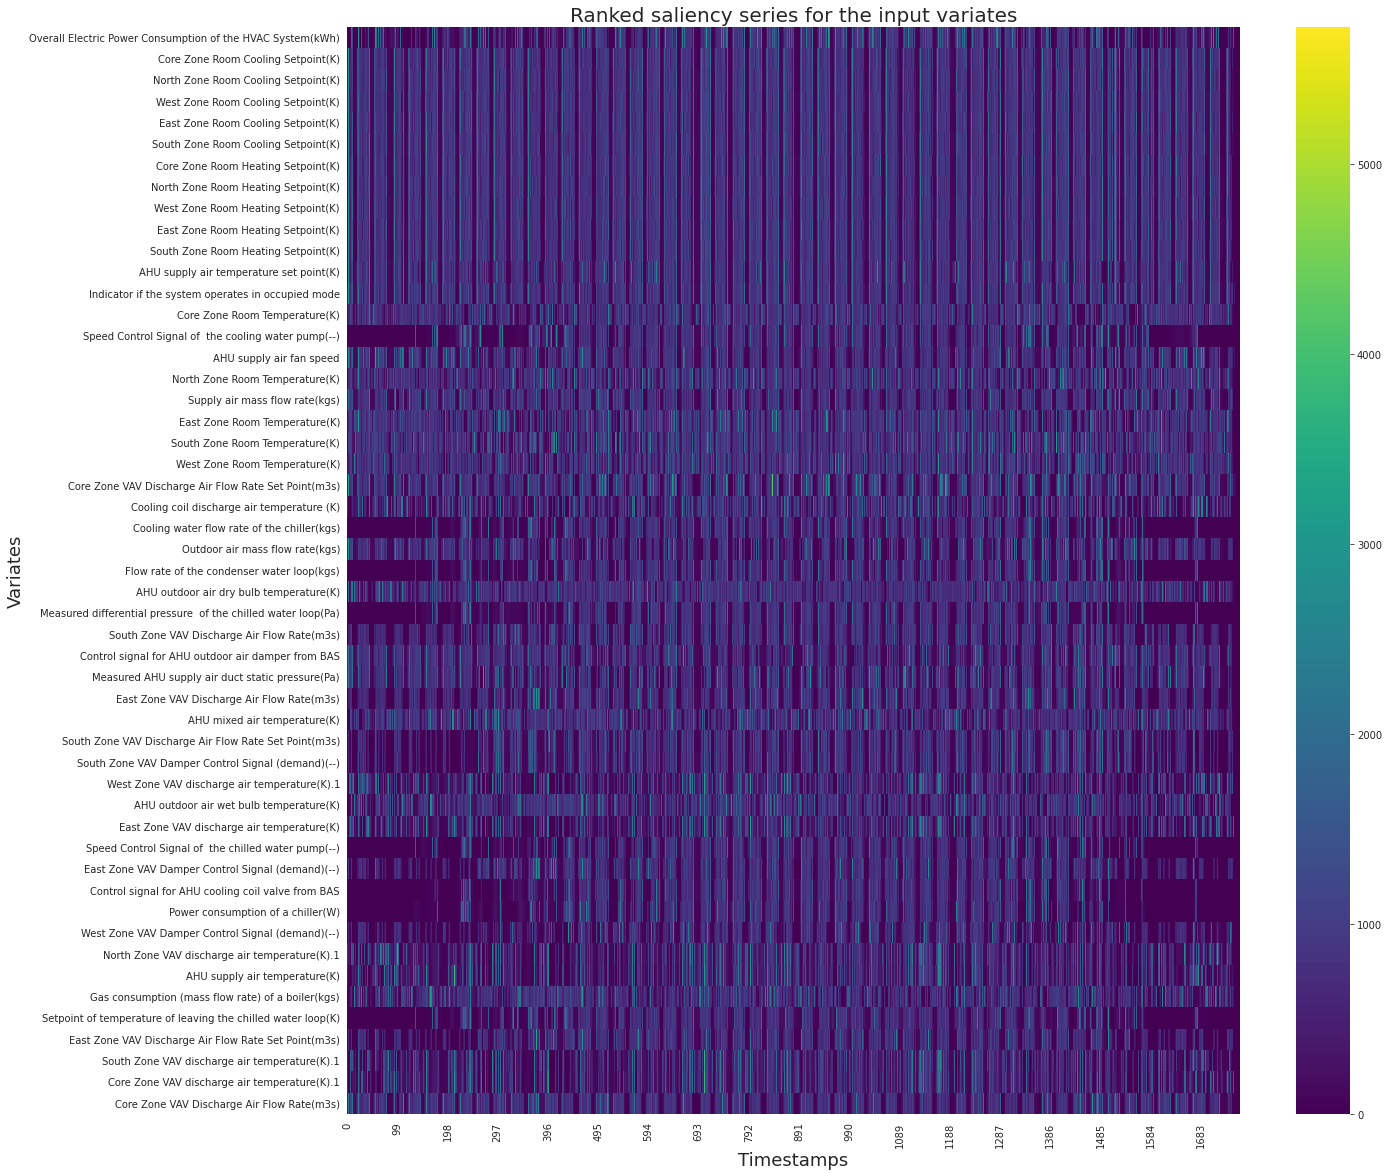

In [9]:
hist_series = pd.read_csv('hist_series.csv')
hist_series_ = hist_series.iloc[:, :]

plt.figure(figsize=(20, 20))
sns.heatmap(data = hist_series_.T, cmap = "viridis")

plt.locator_params('x', nbins=20)
plt.xlabel('Timestamps', fontsize=18)
plt.ylabel("Variates", fontsize=18)
plt.title("Ranked saliency series for the input variates", fontsize=20)
plt.show()

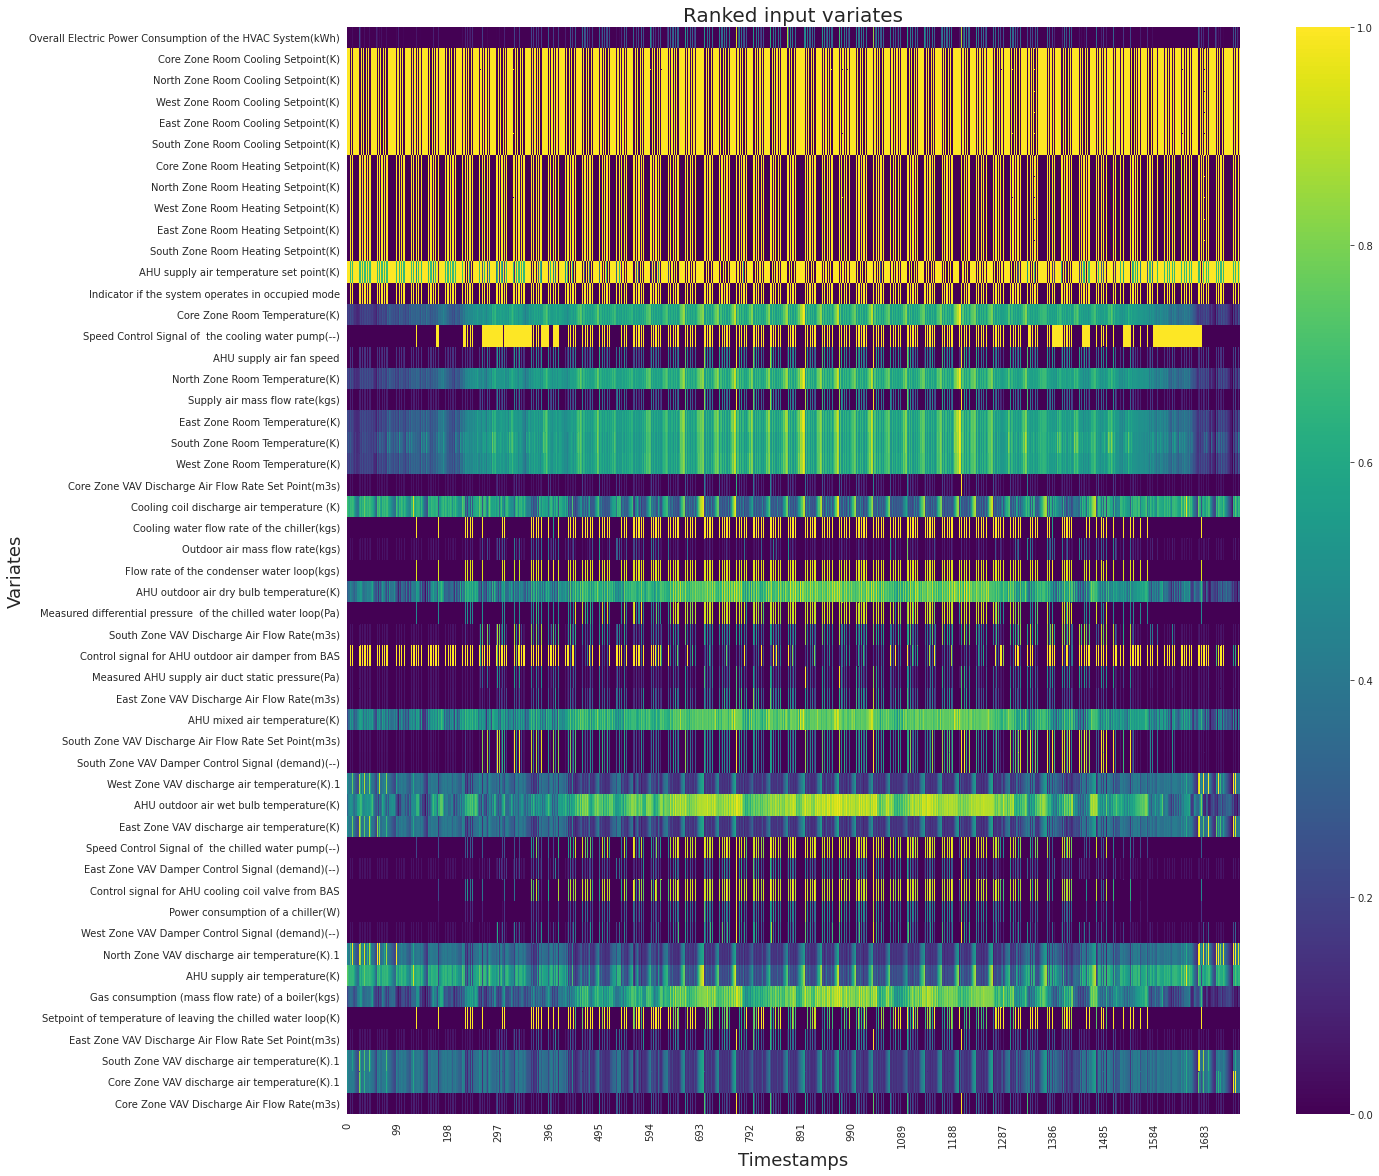

In [10]:
ranked_X_data_ = ranked_X_data[hist_series.columns]
ranked_X_data_ = ranked_X_data_.iloc[:, :]
plt.figure(figsize=(20,20))
sns.set_style('whitegrid')

sns.heatmap(ranked_X_data_.T, cmap="viridis")
plt.locator_params('x', nbins=20)
plt.xlabel('Timestamps', fontsize=18)
plt.ylabel("Variates", fontsize=18)
plt.title("Ranked input variates", fontsize=20)
plt.show()

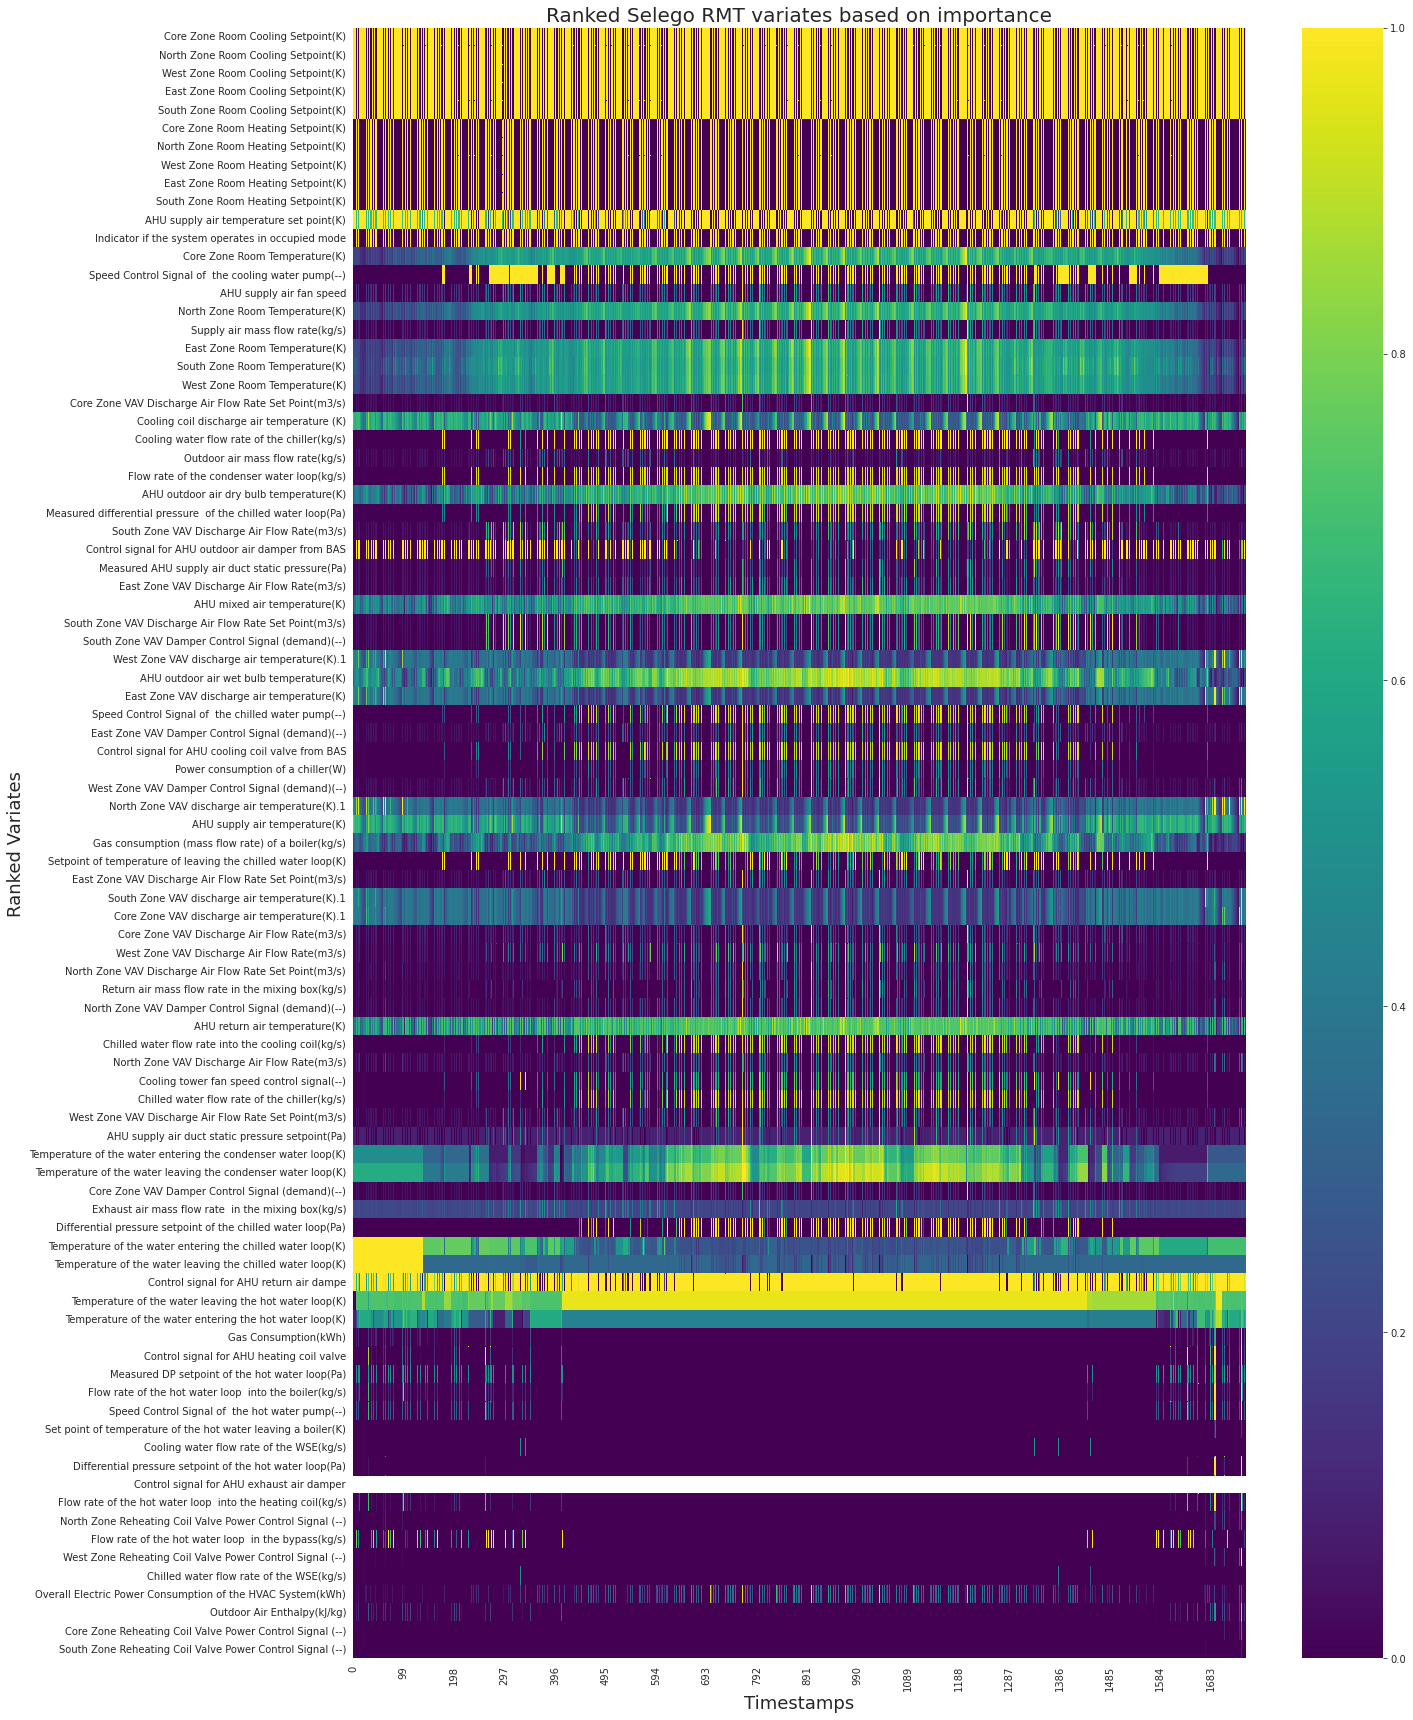

In [11]:
ranked_variates_list = ranked_variates['RankedFeatures'].tolist()
# ranked_variates_list

ranked_X_data = X_input_data[ranked_variates_list]
ranked_X_data.head()

plt.figure(figsize=(20,30))
sns.set_style('whitegrid')

sns.heatmap(ranked_X_data.T, cmap="viridis")
plt.locator_params('x', nbins=20)
plt.xlabel('Timestamps', fontsize=18)
plt.ylabel("Ranked Variates", fontsize=18)
plt.title("Ranked Selego RMT variates based on importance", fontsize=20)
plt.show()

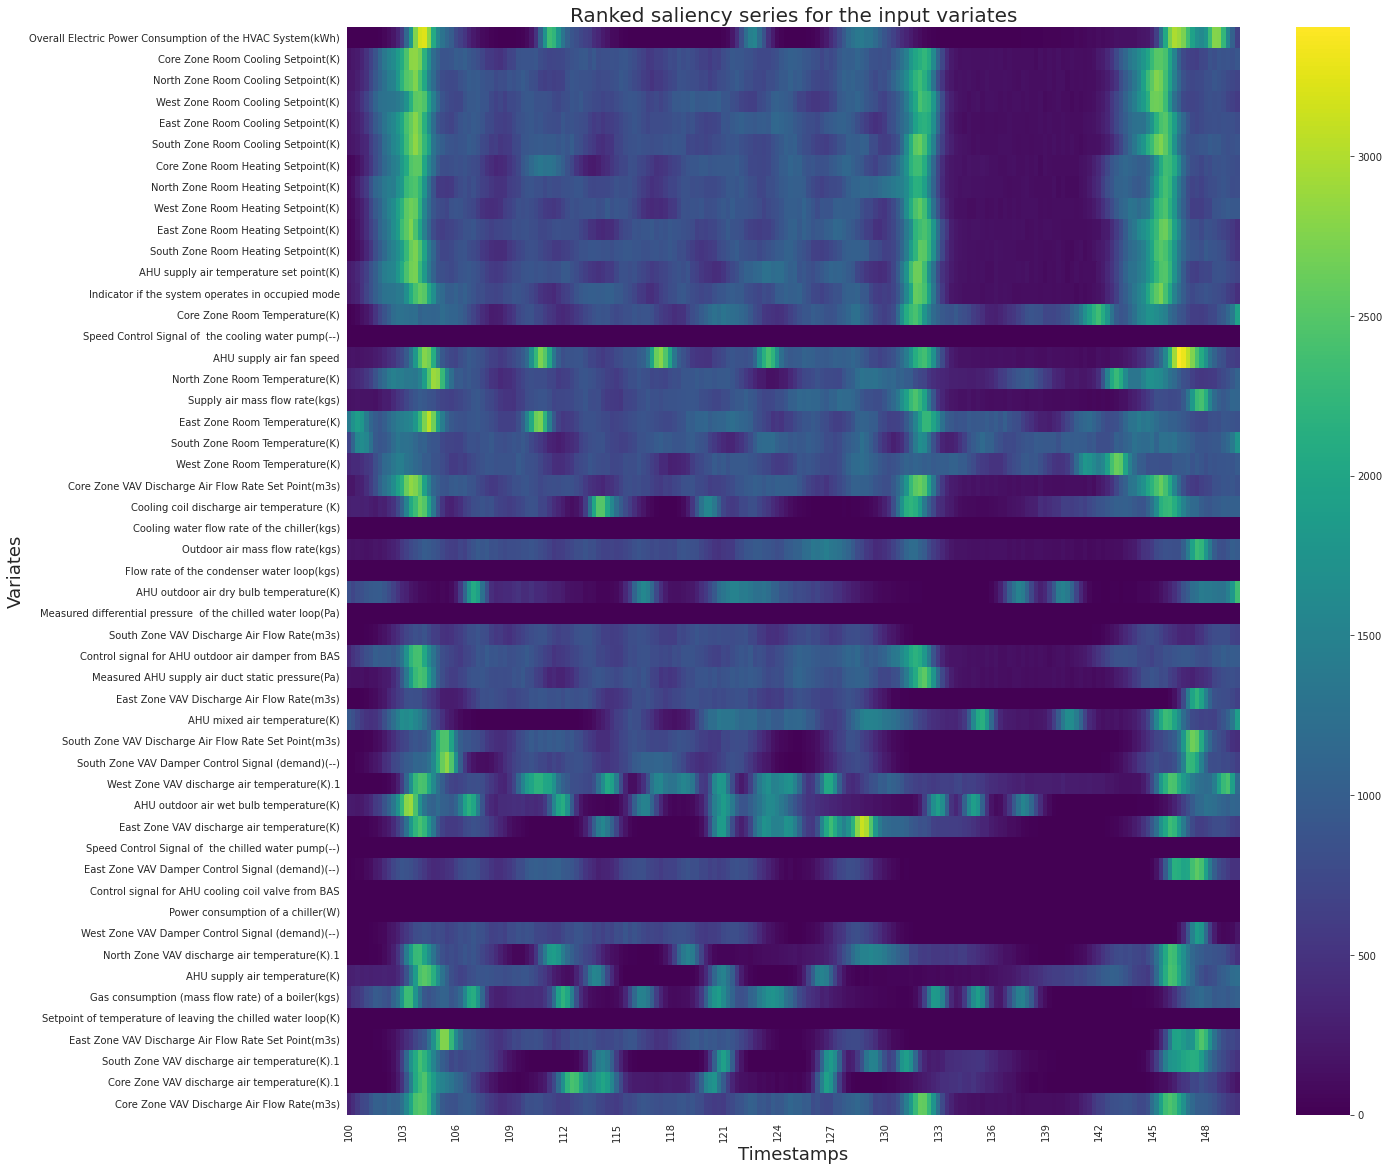

In [12]:
saliency_series = pd.read_csv('hist_series.csv')
saliency_series
saliency_series_part = saliency_series.iloc[100:300, :]
saliency_series_part.head(2)

plt.figure(figsize=(20, 20))
sns.heatmap(data = saliency_series_part.T, cmap = "viridis")

plt.locator_params('x', nbins=20)
plt.xlabel('Timestamps', fontsize=18)
plt.ylabel("Variates", fontsize=18)
plt.title("Ranked saliency series for the input variates", fontsize=20)
plt.show()

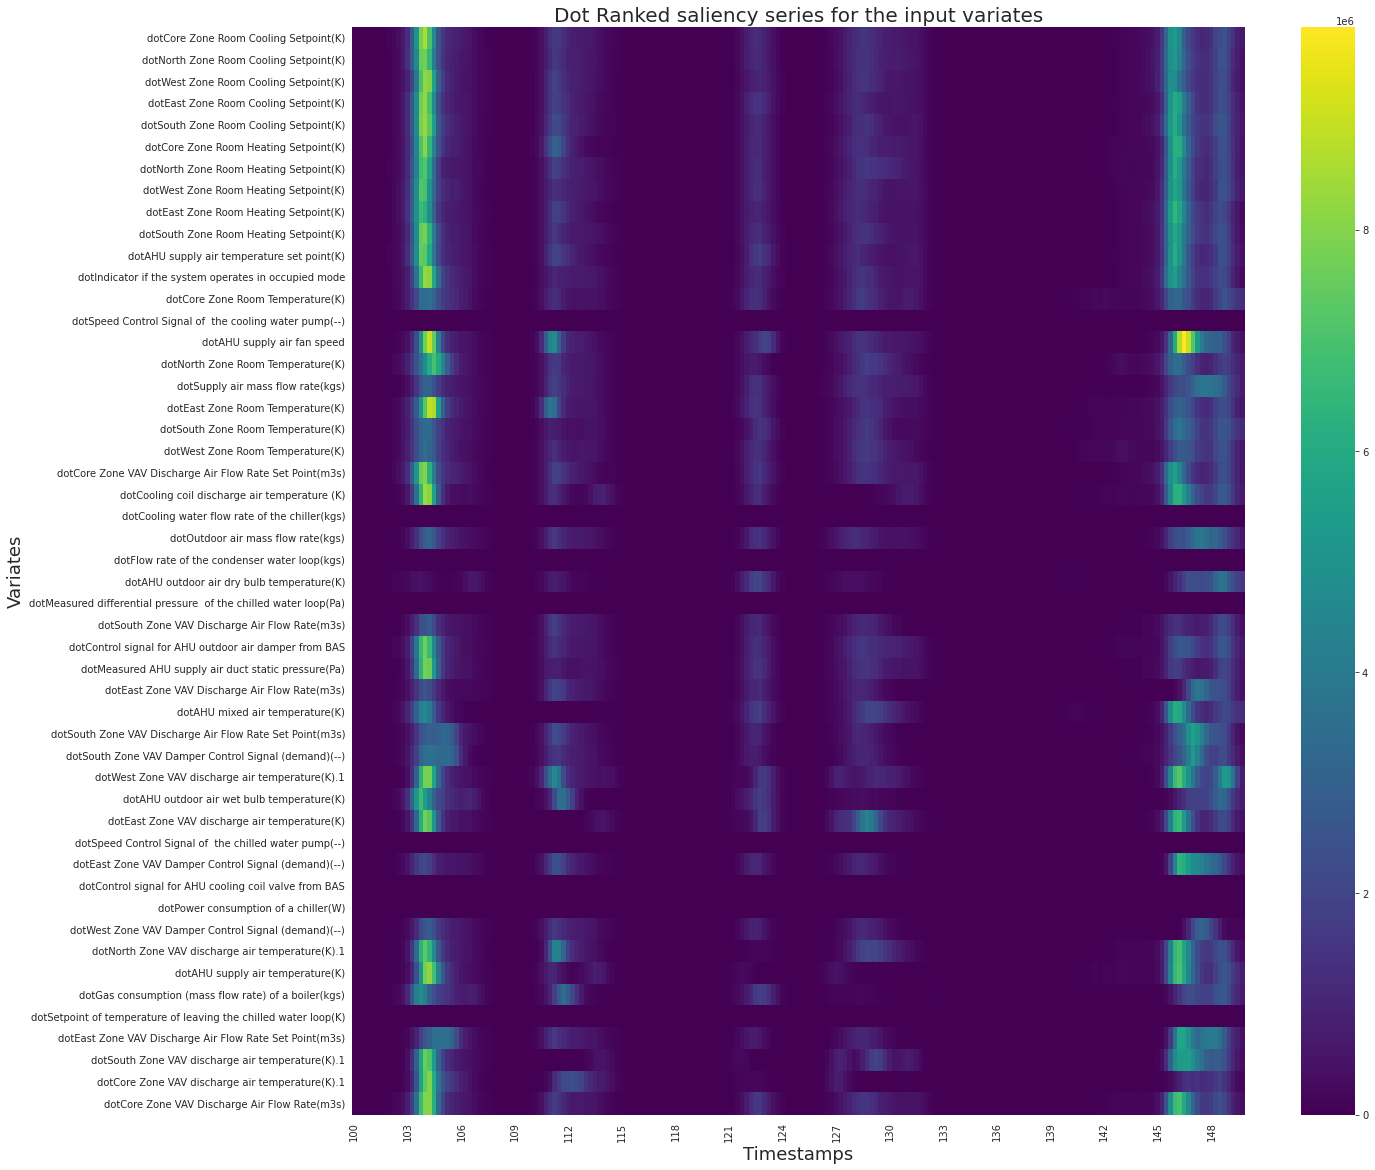

In [13]:
# from IPython import get_ipython
# get_ipython().magic('reset -sf')
""" Dot product between target variates and others """
dot_saliency_series = []
for i in range(len(saliency_series.columns)-1):
    saliency_series['dot'+saliency_series.columns[i+1]] = (saliency_series[saliency_series.columns[0]] * saliency_series[saliency_series.columns[i+1]])
    dot_saliency_series.append(saliency_series['dot'+saliency_series.columns[i+1]])
dot_saliency_series = pd.DataFrame(dot_saliency_series).T
dot_saliency_series.head(2)
##
dot_saliency_series_part = dot_saliency_series.iloc[100:300, :] # shows the indexes 100-300
dot_saliency_series_part

plt.figure(figsize=(20, 20))
sns.heatmap(data = dot_saliency_series_part.T, cmap = "viridis")

plt.locator_params('x', nbins=20)
plt.xlabel('Timestamps', fontsize=18)
plt.ylabel("Variates", fontsize=18)
plt.title("Dot Ranked saliency series for the input variates", fontsize=20)
plt.show()

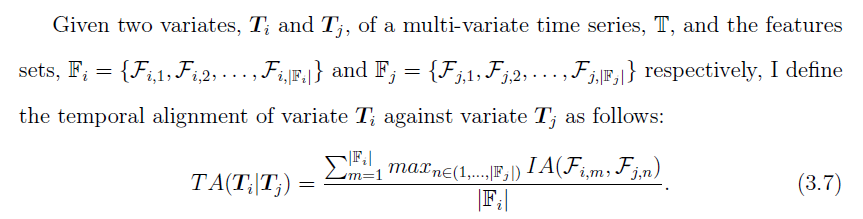

In [15]:
## Get the indexes where there is possible RMT features using heat map
# Using median for now
    
    
def avg_3_sigma(df):
    df = df[np.abs(df - df.mean()) <= (3*df.std())]
    return df.mean()


""" Function to find the index where there is RMTfeatures """
def index_data(pd_series, timestamp_offset):
    a = np.where(pd_series > pd.DataFrame(pd_series).apply(avg_3_sigma, axis=0)[0])
    b = [x+timestamp_offset for x in a][0]
    return b

## RMT features from variates
""" Function to find list of RMT features where each sublist is an one RMTFeature """
from collections import OrderedDict
def RMTFeaturesList(input_list):
    outer_list=[]
    inner_list=[]
    i=0
    while i < len(input_list):
        inner_list.append(input_list[i])
        if i != len(input_list)-1:
            if input_list[i+1] != input_list[i]+1:
                outer_list.append(inner_list)
                inner_list = []
            else:
                outer_list.append(inner_list)
        i=i+1
    
    return list(map(list, OrderedDict.fromkeys(map(tuple, outer_list))))


## Interval Alignment 
""" Function to find the measure of "Interval Alignment" and also their corresponding timestamp list """
def IA(RMTfeatures_target, RMTfeatures_regular):
    
    Interval_Alignment_RMTfeatures = []
    overlap_list = []
    for feature_i in RMTfeatures_target:
        if len(feature_i) > 1:
            t_start_i = feature_i[0]
            t_end_i = feature_i[-1]
        elif len(feature_i) == 1:
            t_start_i = feature_i[0]
            t_end_i = feature_i[0]
        else:
            t_start_i = 0
            t_end_i = 0

        Interval_Alignment_target = []
        overlap_target = []
        for feature_j in RMTfeatures_regular:
            if len(feature_j) > 1:
                t_start_j = feature_j[0]
                t_end_j = feature_j[-1]
            elif len(feature_j) == 1:
                t_start_j = feature_j[0]
                t_end_j = feature_j[0]
            else:
                t_start_j = 0
                t_end_j = 0

            begin = max(t_start_i, t_start_j)
            end = min(t_end_i, t_end_j)

            # overlap(F1, F2) = min(t_end_1, t_end_2) - max(t_start_1, t_start_2)
            overlap_F_i_F_j = end - begin
            if overlap_F_i_F_j >= 0:
                Interval_Align_F_i_F_j = overlap_F_i_F_j
            else:
                Interval_Align_F_i_F_j = 0

            Interval_Alignment_target.append(Interval_Align_F_i_F_j)

            overlap_F_i_F_j = list(range(begin, end))
            overlap_target.append(overlap_F_i_F_j)

        Interval_Alignment_RMTfeatures.append(Interval_Alignment_target)

        overlap_list.append(overlap_target)
      
    return Interval_Alignment_RMTfeatures, overlap_list


# IA_check, IA_list_check = IA(RMTfeatures_target, RMTfeatures_regular)

# print("No. of Interval Alignment: ", IA_check)
# print("\n\nOverlap list between target and regualar variates: \n", IA_list_check)

## Temporal Alignment

from IPython.display import Image
Image("Temporal_Alignment equation.PNG")

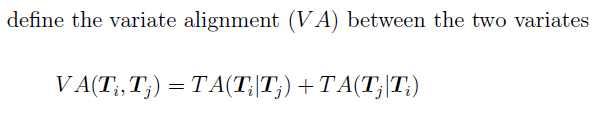

In [16]:
## Temporal Alignment
def TA(target_var_ = 1, regular_var_ = 2, offset=3):
    temporal_align_max_overlap = []
    
    target_var_features = index_data(target_var_, offset)
    regular_var_features = index_data(regular_var_, offset)
    RMTfeatures_target = RMTFeaturesList(target_var_features)
    RMTfeatures_regular = RMTFeaturesList(regular_var_features)
    
    IA_number, IA_overlap_list = IA(RMTfeatures_target, RMTfeatures_regular)
    print(IA_overlap_list)
    for lst in IA_overlap_list:
        if len(lst) > 1:
            max_IA_overlap_list = max(lst, key = len)
        #         max_IA_overlap_list = [item/len(RMTfeatures_target) for item in max_IA_overlap_list]
            temporal_align_max_overlap.append(max_IA_overlap_list)
    return temporal_align_max_overlap

## Variate Alignment
from IPython.display import Image
Image("Variate_Alignment equation.PNG")

In [17]:
## Variate Alignment
offset = 100

All_VA_align = []

for i in range(len(saliency_series_part.columns)-1):
    target_variate = saliency_series_part[saliency_series_part.columns[0]]
    regular_variate = saliency_series_part[saliency_series_part.columns[i+1]]
    VA_align = TA(target_variate, regular_variate, offset) + TA(regular_variate, target_variate, offset)
    All_VA_align.append(VA_align)



[[[112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125], [], [], [], [], [], [], [], [], [], [], [], []], [[], [], [150, 151, 152, 153], [], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [188, 189], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [210, 211, 212, 213, 214, 215, 216, 217], [], [222], [], [], []], [[], [], [], [], [], [], [], [], [], [], [281, 282, 283, 284, 285], [], [295, 296, 297, 298]]]
[[[112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125], [], [], [], []], [[], [], [], [], []], [[], [150, 151, 152, 153], [], [], []], [[], [], [], [], []], [[], [], [], [], []], [[], [], [188, 189], [], []], [[], [], [], [], []], [[], [], [], [210, 211, 212, 213, 214, 215, 216, 217], []], [[], [], [], [], []], [[], [], [], [222], []], [[], [], [], [], [281, 282, 283, 284, 285]], [[], [], [], [], []], [[], [], [], [], [295, 296, 297, 298]]]
[[[112, 113, 114, 115, 116, 117, 118, 119], [125], [], [], [], [], [], [], [], [], [], [],

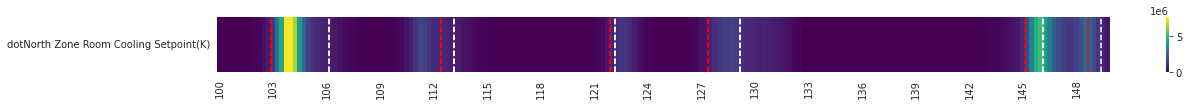

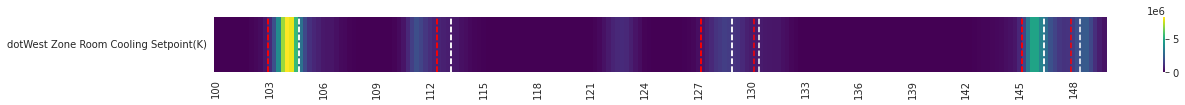

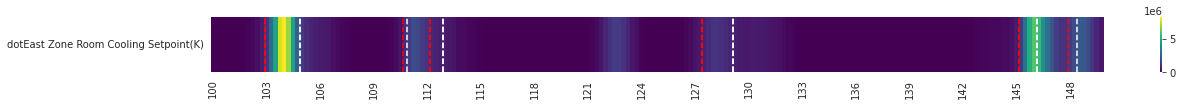

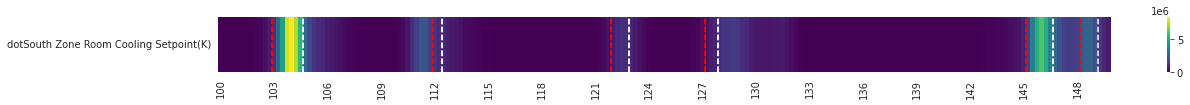

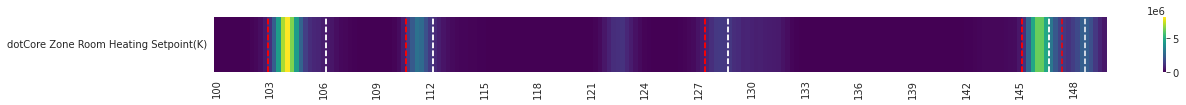

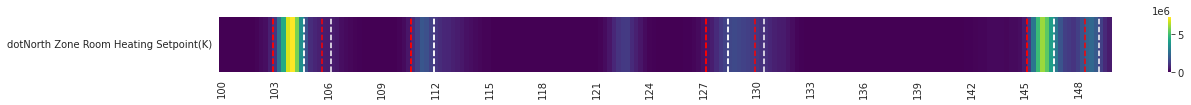

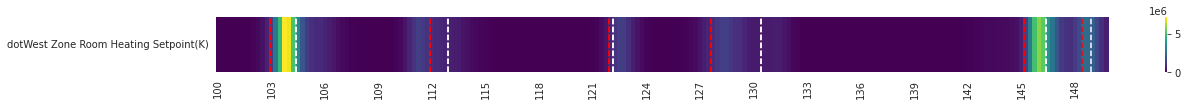

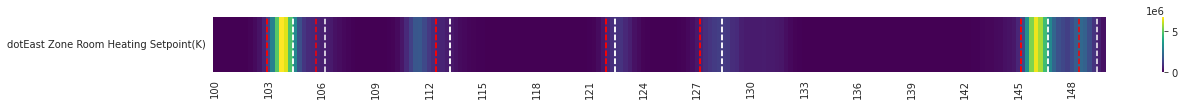

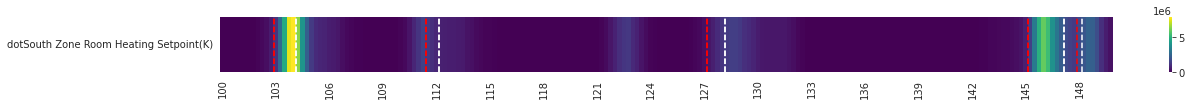

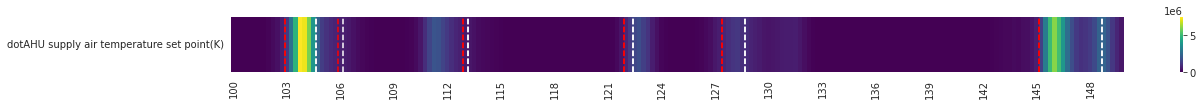

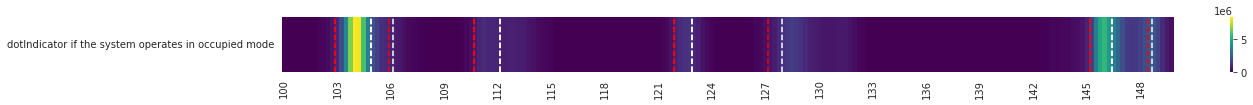

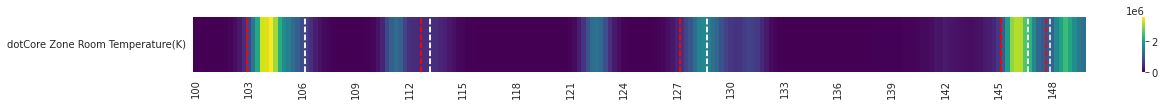

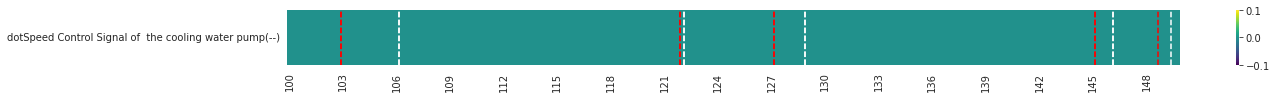

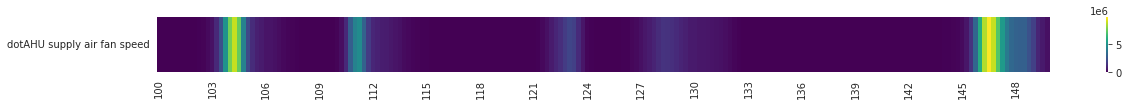

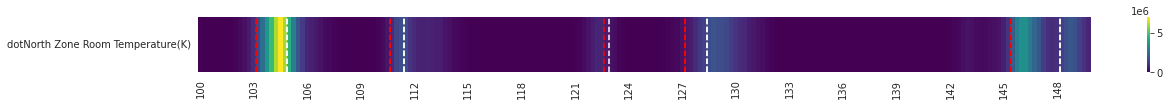

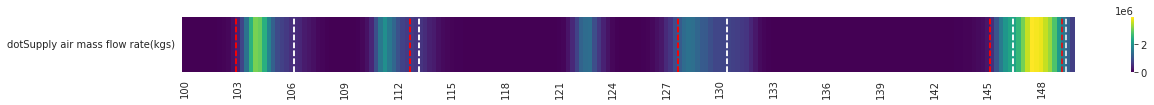

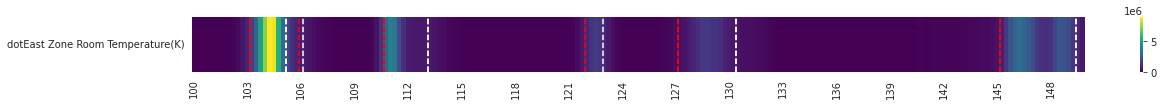

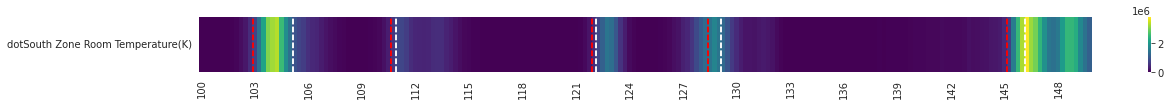

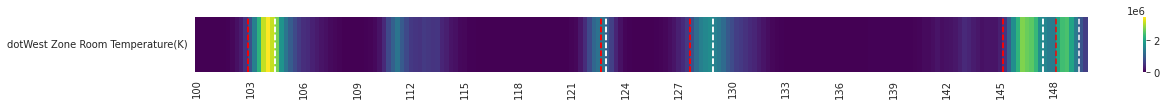

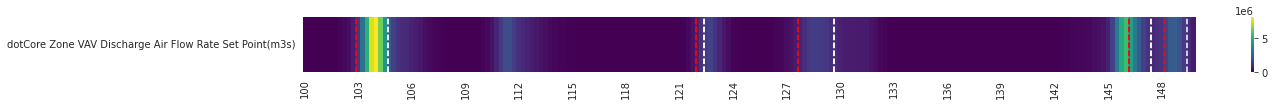

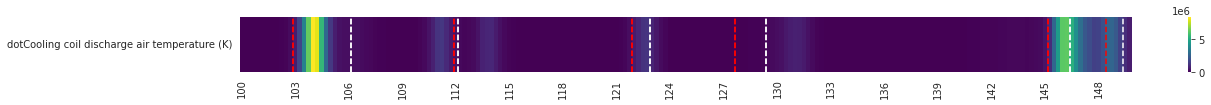

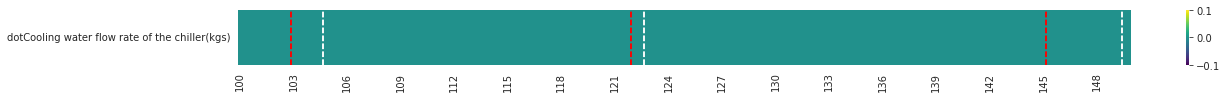

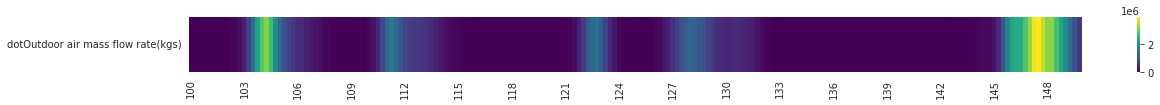

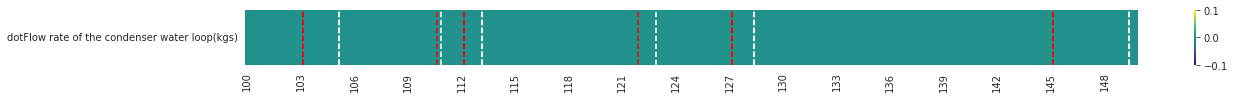

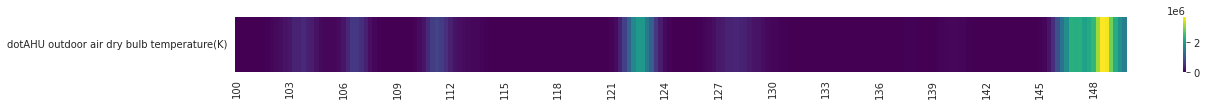

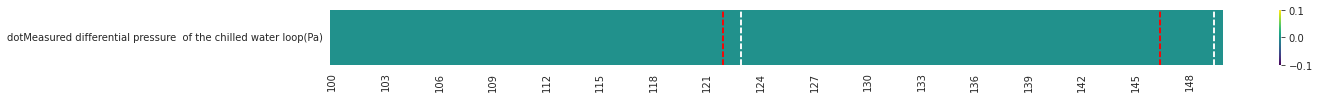

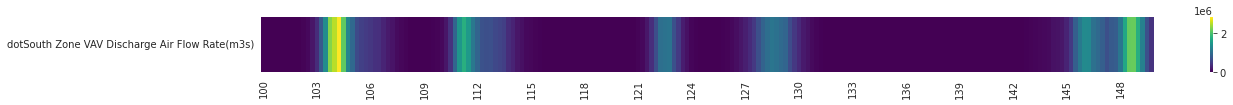

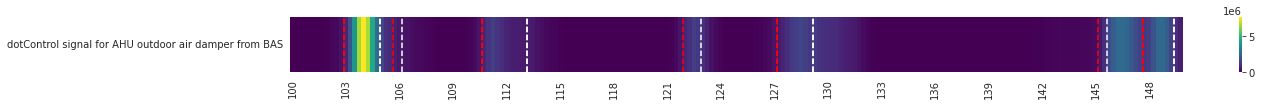

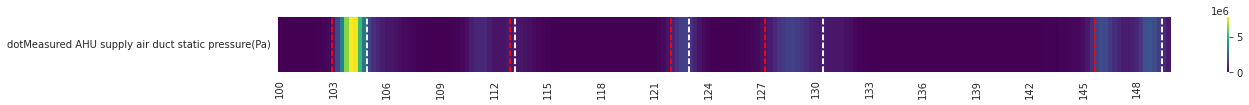

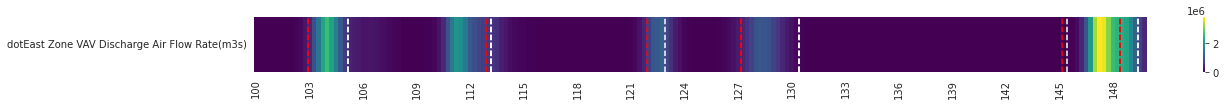

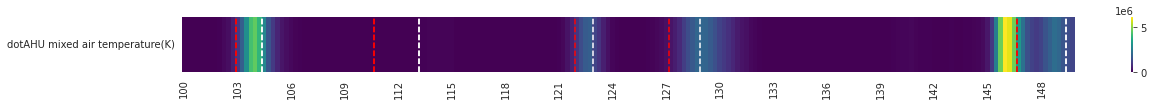

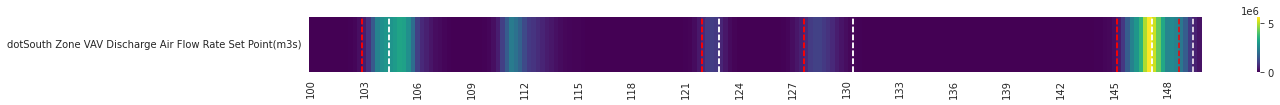

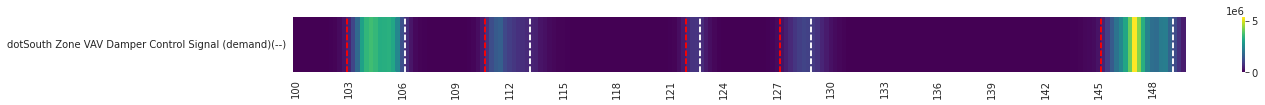

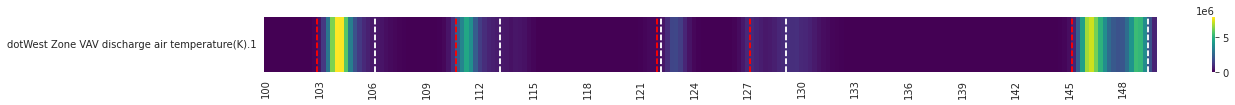

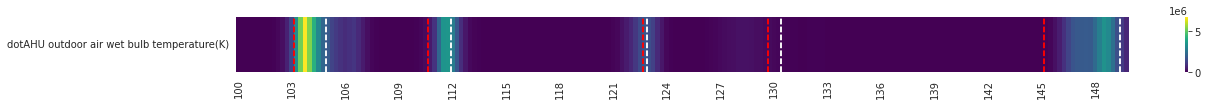

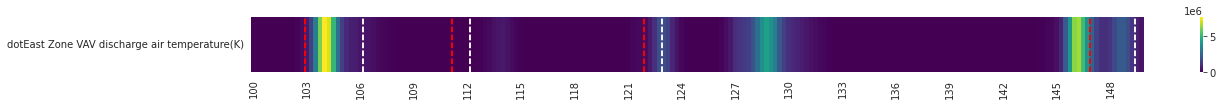

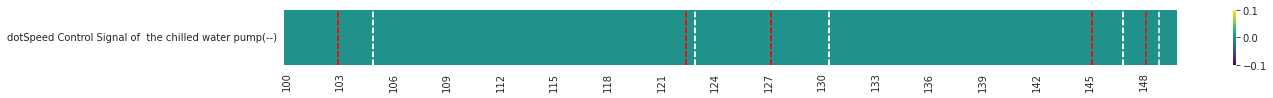

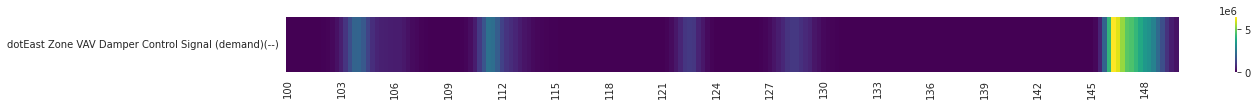

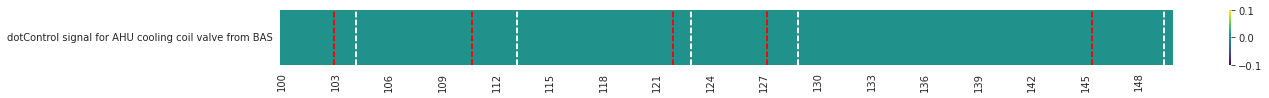

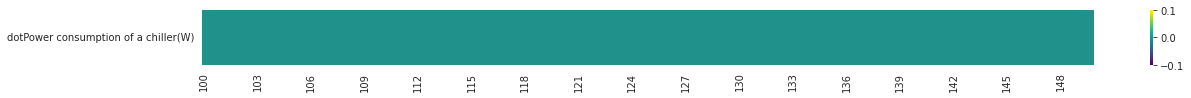

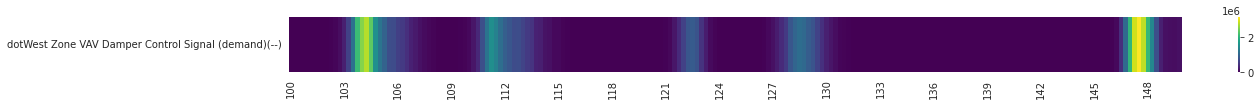

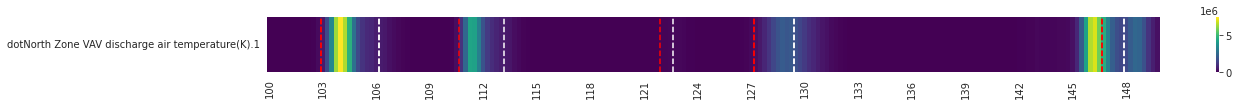

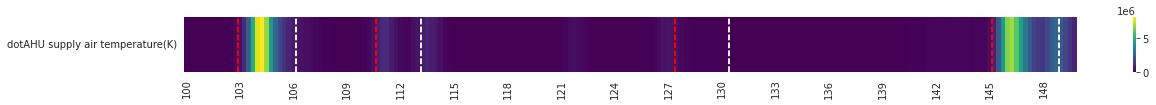

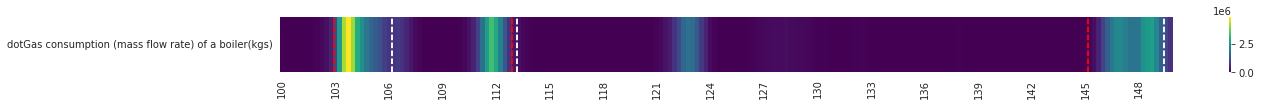

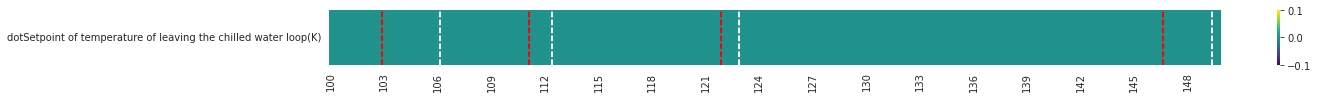

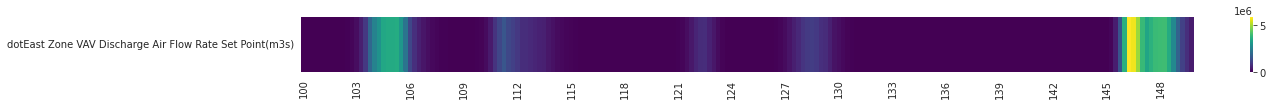

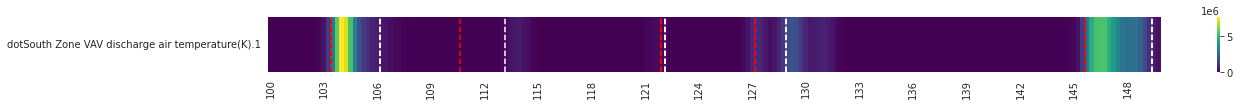

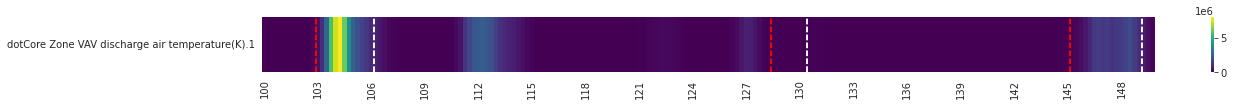

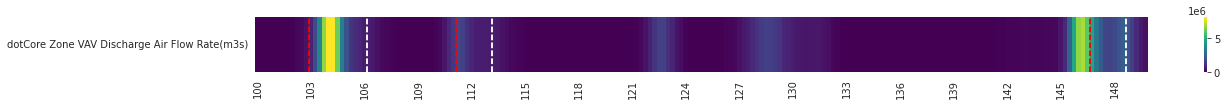

In [18]:
target_variate = saliency_series_part[[saliency_series_part.columns[0]]]
regular_variate = saliency_series_part[[saliency_series_part.columns[i+1]]]
data = pd.concat([target_variate, regular_variate], axis=1)
# data

# ## Heatmaps for dot_saliencyseries
# plt.figure(figsize=(20, 20))
all_data = []
for i in range(len(dot_saliency_series_part.columns)-1):
#     target_variate = dot_saliency_series_part[[dot_saliency_series_part.columns[0]]]
    regular_variate = dot_saliency_series_part[[dot_saliency_series_part.columns[i+1]]]
#     data = pd.concat([target_variate, regular_variate], axis=1)
#     all_data.append(data)
    all_data.append(regular_variate)

    
for i in range(len(all_data)):
    plt.figure(figsize=(20, 1))
    sns.heatmap(data = all_data[i].T, cmap = "viridis")

    for lines in All_VA_align[i]:
        if len(lines) > 1:
            offset = 100
            start = lines[0] - offset
            plt.axvline(x=start, linestyle = '--', color="r")
            end = lines[-1] - offset
            plt.axvline(x=end, linestyle = '--', color="w")

    plt.locator_params('x', nbins=20)
    locs, labels = plt.yticks()
    plt.setp(labels, rotation=0)
    # plt.xlabel('Timestamps', fontsize=18)
#     plt.ylabel("Variates", fontsize=18)
#     plt.title("Saliency series for the input variates", fontsize=20)

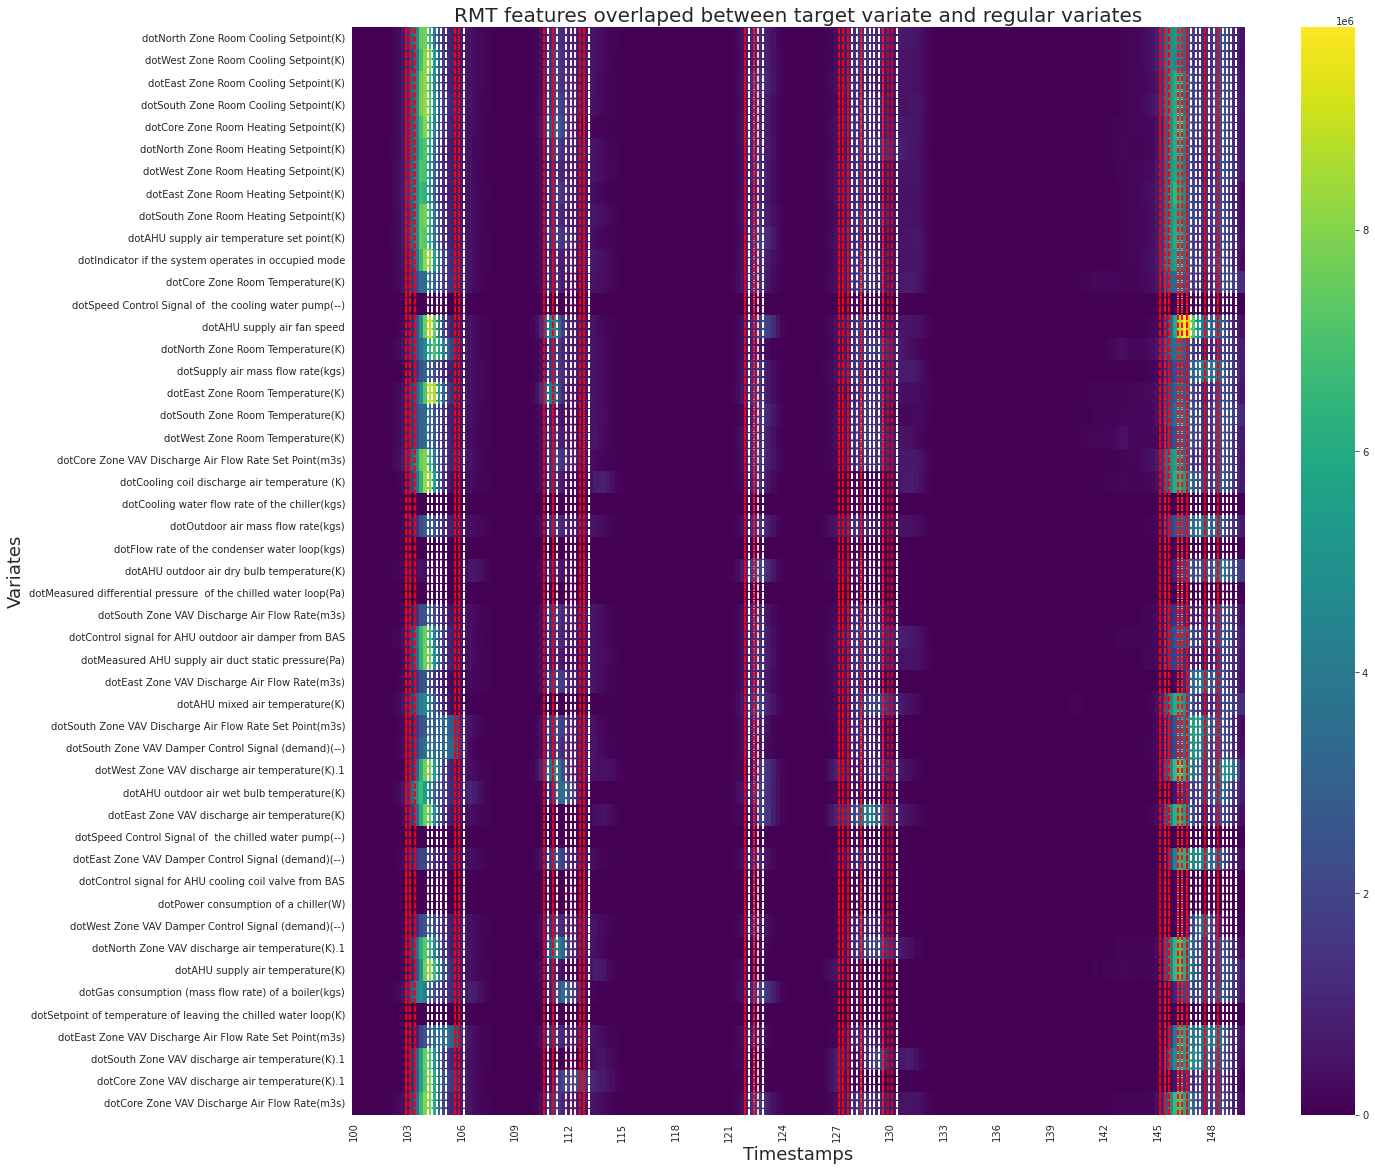

In [19]:
## Heatmaps for dot_saliencyseries
plt.figure(figsize=(20, 20))
sns.heatmap(data = dot_saliency_series_part.T.iloc[1:, :], cmap = "viridis")

for VA_align in All_VA_align:
    for lines in VA_align:
#         print(lines)      
        if len(lines) > 1:
            offset = 100
            start = lines[0] - offset
            plt.axvline(x=start, linestyle = '--', color="r")
            end = lines[-1] - offset
            plt.axvline(x=end, linestyle = '--', color="w")

plt.locator_params('x', nbins=20)
plt.xlabel('Timestamps', fontsize=18)
plt.ylabel("Variates", fontsize=18)
plt.title("RMT features overlaped between target variate and regular variates", fontsize=20)
plt.show()

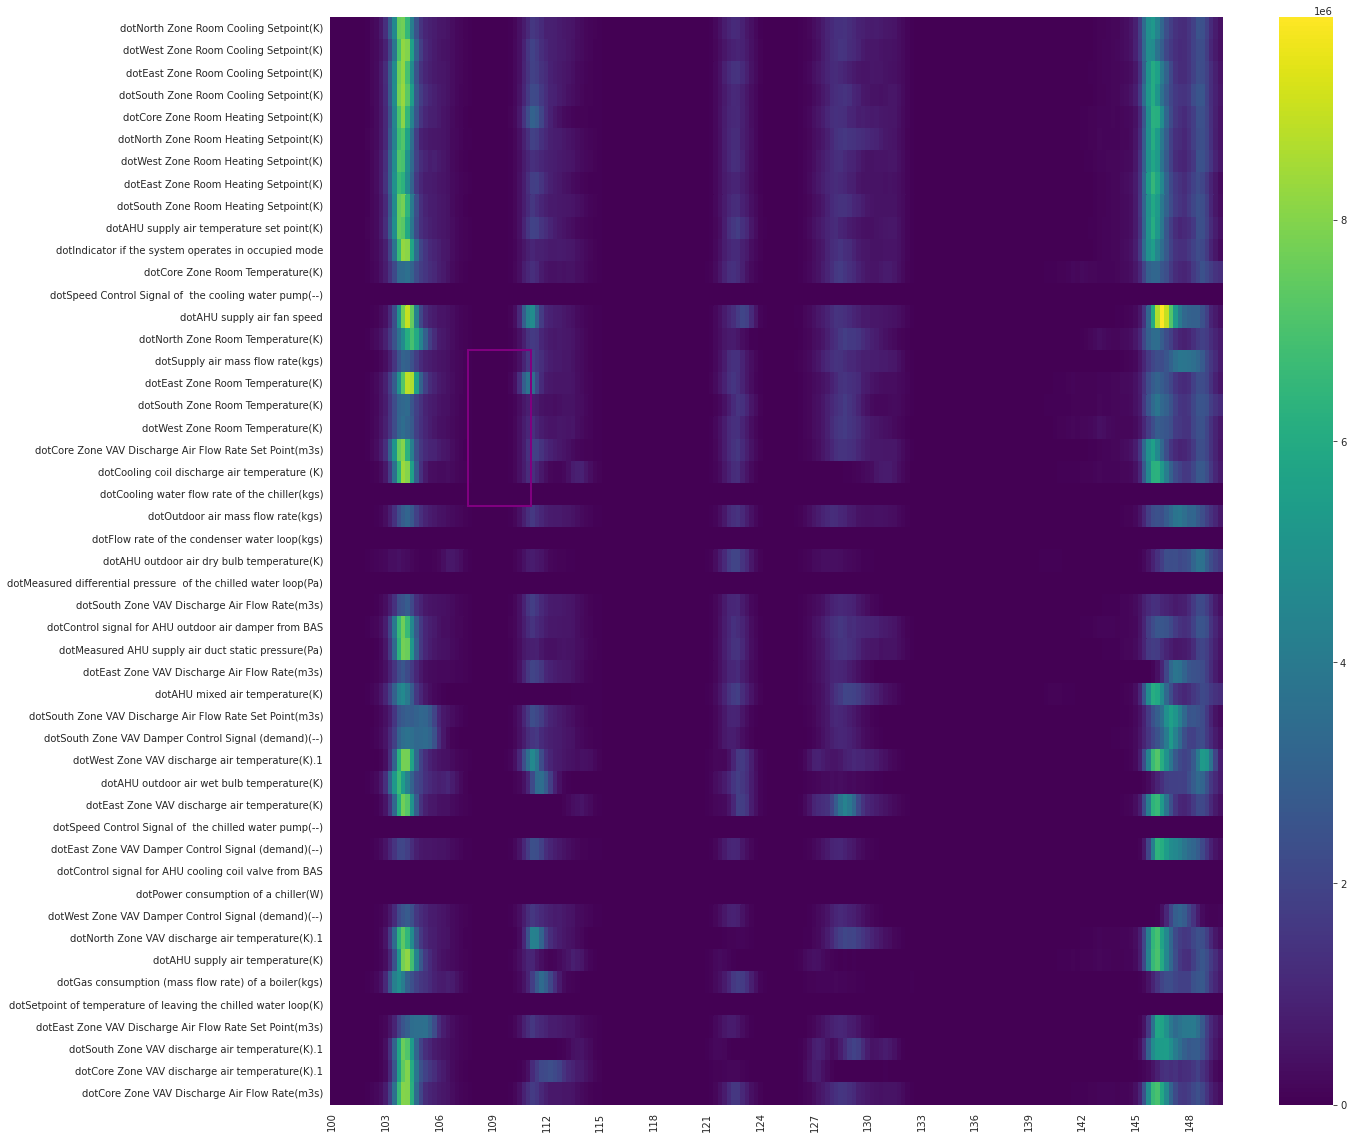

In [20]:
plt.figure(figsize=(20, 20))
sns.heatmap(data = dot_saliency_series_part.T.iloc[1:, :], cmap = "viridis")
plt.locator_params('x', nbins=20)



import matplotlib.patches as mpatches
left, bottom, width, height = (31, 15, 14, 7)

for VA_align in All_VA_align:
    for lines in VA_align:
#         print(lines)      
        if len(lines) > 1:
            offset = 100
            start = lines[0] - offset
#             plt.axvline(x=start, linestyle = '--', color="r")
            end = lines[-1] - offset
#             plt.axvline(x=end, linestyle = '--', color="w")
            rect = mpatches.Rectangle((left, bottom), width, height)
            
            
rect=mpatches.Rectangle((left,bottom),width,height, 
                        fill=False,
                        color="purple",
                       linewidth=2)
                       #facecolor="red")
plt.gca().add_patch(rect)


plt.show()

## Heatmap

In [21]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))

    # ... and label them with the respective list entries
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)


#     # Let the horizontal axes labeling appear on top.
#     ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

#     # Rotate the tick labels and set their alignment.
#     plt.setp(ax.get_xticklabels(), rotation=-30, ha="right", rotation_mode="anchor")

#     # Turn spines off and create white grid.
#     ax.spines[:].set_visible(False)

#     ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
#     ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
#     ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
#     ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


# def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
#                      textcolors=("black", "white"),
#                      threshold=None, **textkw):
#     """
#     A function to annotate a heatmap.

#     Parameters
#     ----------
#     im
#         The AxesImage to be labeled.
#     data
#         Data used to annotate.  If None, the image's data is used.  Optional.
#     valfmt
#         The format of the annotations inside the heatmap.  This should either
#         use the string format method, e.g. "$ {x:.2f}", or be a
#         `matplotlib.ticker.Formatter`.  Optional.
#     textcolors
#         A pair of colors.  The first is used for values below a threshold,
#         the second for those above.  Optional.
#     threshold
#         Value in data units according to which the colors from textcolors are
#         applied.  If None (the default) uses the middle of the colormap as
#         separation.  Optional.
#     **kwargs
#         All other arguments are forwarded to each call to `text` used to create
#         the text labels.
#     """

#     if not isinstance(data, (list, np.ndarray)):
#         data = im.get_array()

#     # Normalize the threshold to the images color range.
#     if threshold is not None:
#         threshold = im.norm(threshold)
#     else:
#         threshold = im.norm(data.max())/2.

#     # Set default alignment to center, but allow it to be
#     # overwritten by textkw.
#     kw = dict(horizontalalignment="center",
#               verticalalignment="center")
#     kw.update(textkw)

#     # Get the formatter in case a string is supplied
#     if isinstance(valfmt, str):
#         valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

#     # Loop over the data and create a `Text` for each "pixel".
#     # Change the text's color depending on the data.
#     texts = []
#     for i in range(data.shape[0]):
#         for j in range(data.shape[1]):
#             kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
#             text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
#             texts.append(text)

#     return texts


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

#     # Normalize the threshold to the images color range.
#     if threshold is not None:
#         threshold = im.norm(threshold)
#     else:
#         threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    
    for VA_align in All_VA_align:
        for lines in VA_align:
    #         print(lines)      
            if len(lines) > 1:
            
#                 offset = 100
#                 start = lines[0] - offset
#                 plt.axvline(x=start, linestyle = '--', color="r")
#                 end = lines[-1] - offset
#                 plt.axvline(x=end, linestyle = '--', color="w")

    
                return texts

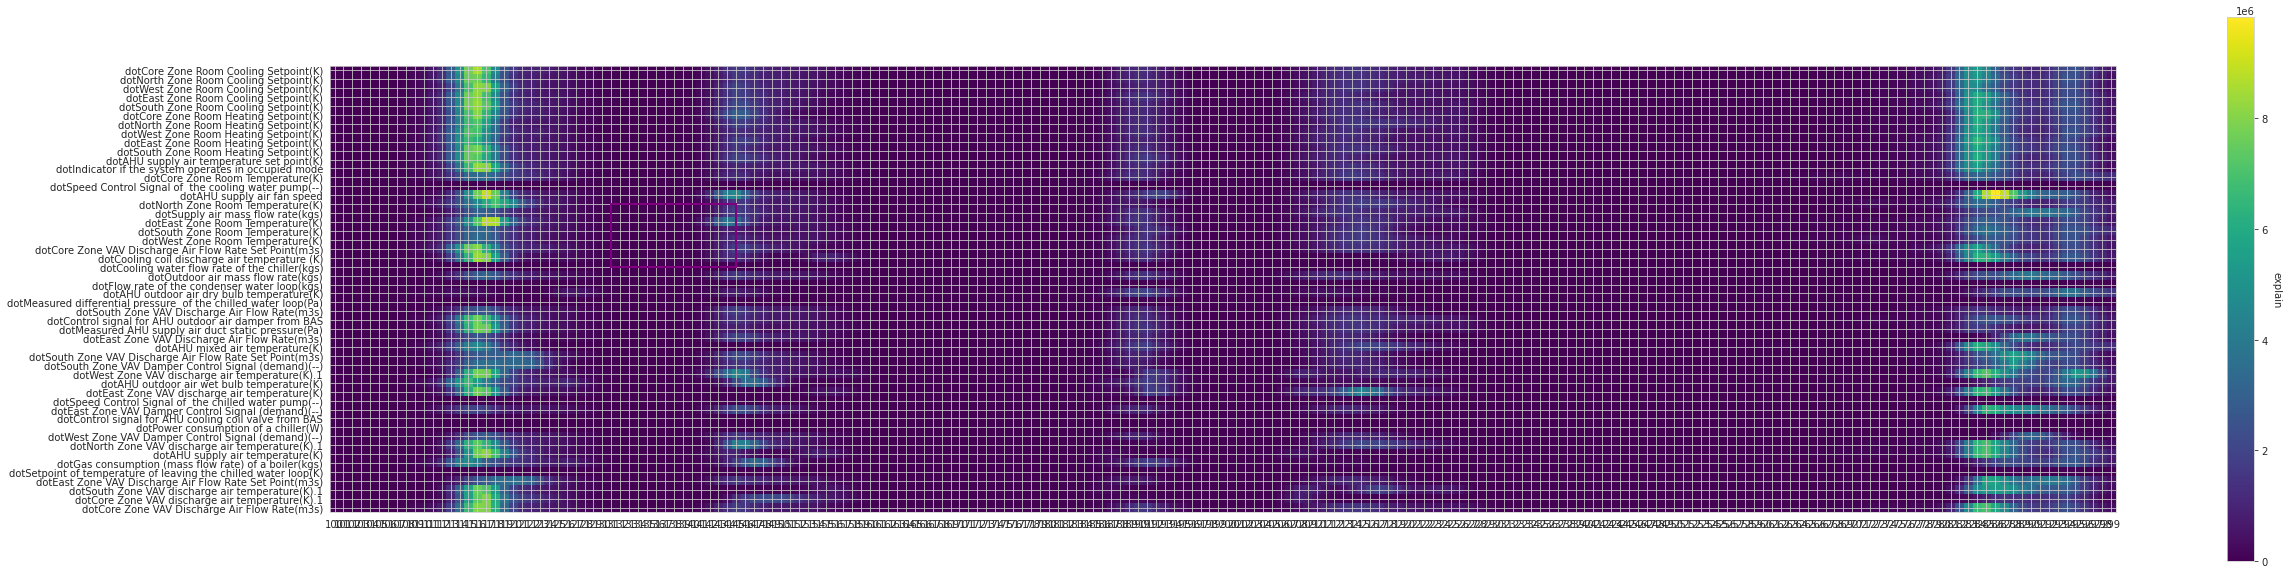

In [22]:
data_heatmap = dot_saliency_series_part.T
sensors_name = dot_saliency_series_part.iloc[:, 0:].columns.tolist()
time_stamp = dot_saliency_series_part.iloc[:, 0:].index.tolist()
# print(time_stamp)
dot_saliency_series_np = np.array(data_heatmap)
dot_saliency_series_np.shape


fig, ax = plt.subplots(figsize=(40, 10))


# im, cbar = heatmap(harvest, vegetables, farmers, ax=ax, cmap="viridis", cbarlabel="harvest [t/year]")
im, cbar = heatmap(dot_saliency_series_np, sensors_name, time_stamp, ax=ax, cmap="viridis", cbarlabel="explain")

rect=mpatches.Rectangle((left,bottom),width,height, 
                        fill=False,
                        color="purple",
                       linewidth=2)
                       #facecolor="red")
plt.gca().add_patch(rect)
# texts = annotate_heatmap(im, valfmt="{x:.1f} t")

# fig.tight_layout()
plt.show()